In [1]:
import jax
import jax.numpy as jnp
import numpyro
import numpy as np
import blackjax
import numpyro.distributions as dist
import matplotlib.pyplot as plt

/Users/madhav/anaconda3/envs/experiment-new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

In [3]:
def eight_schools():
    mu = numpyro.sample('mu', dist.Normal(2, 5))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    theta = numpyro.sample('theta', dist.Normal(jnp.full(J,mu), tau))
    numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

In [4]:
num_warmup = 500

adapt = blackjax.window_adaptation(blackjax.nuts, eight_schools)
key = jax.random.PRNGKey(0)
(last_state, parameters), intermediate_states,logdensity_fn  = adapt.run(key, num_warmup)
kernel = blackjax.nuts(logdensity_fn , **parameters).step

centeredness [0.3035308  0.03845292 0.16873685 0.96475405 0.1387696  0.9244353
 0.35561895 0.12999162]
centeredness [0.14344071 0.05820376 0.02024461 0.0766812  0.04357345 0.16257288
 0.12011635 0.07107519]
centeredness [6.1478224e-02 8.9808516e-02 1.9221745e-02 2.2248485e-06 9.3503147e-03
 4.8371848e-02 4.3674756e-02 5.5662863e-02]
centeredness [0.03884485 0.05708414 0.03757405 0.03870853 0.0546757  0.04828643
 0.04516163 0.0430852 ]


In [5]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, (
        infos.acceptance_rate,
        infos.is_divergent,
        infos.num_integration_steps,
    )

In [6]:
num_sample = 1000

states, infos = inference_loop(key, kernel, last_state, num_sample)
_ = states.position["mu"].block_until_ready()

In [7]:
def scatterplt(samples):
    fig, axes = plt.subplots(4, 2, figsize=(10, 12))
    axes = axes.flatten()
    # reparam_sample, mvn, mu_theta, std_theta = reparameterize_samples_dist(samples, best_c)
    # reparam_sample = reparam_sample if reparam else samples['theta'].T
    samples_theta = samples['theta_decentered'].T
    for i in range(8):
        axes[i].scatter(samples_theta[i], samples['tau'])
        axes[i].set_xlabel(f'theta_{i}')
        axes[i].set_ylabel('log_std')

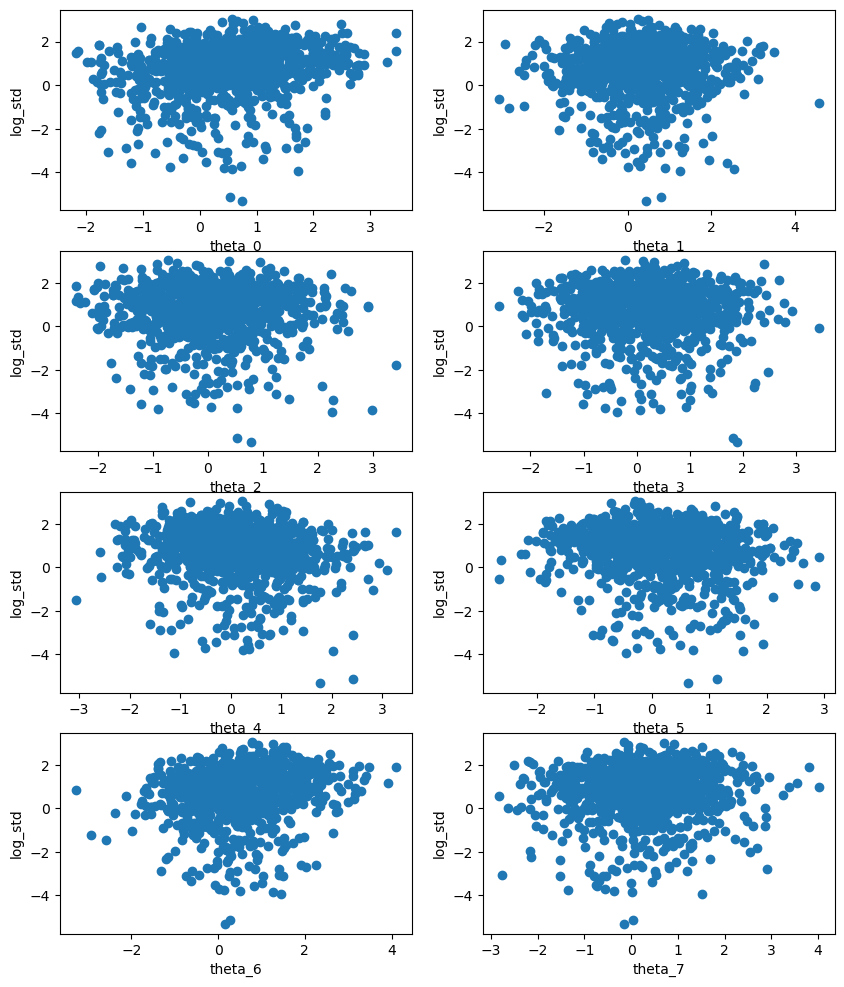

In [8]:
scatterplt(states[0])